In [ ]:
!apt-get -q install davfs2

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libneon27
The following NEW packages will be installed:
  davfs2 libneon27
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 258 kB of archives.
After this operation, 627 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libneon27 amd64 0.32.2-1 [102 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 davfs2 amd64 1.6.1-1 [155 kB]
Fetched 258 kB in 1s (322 kB/s)
Preconfiguring packages ...
Selecting previously unselected package libneon27:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libneon27_0.32.2-1_amd64.deb ...
Unpacking libneon27:amd64 (0.32.2-1) ...
Selecting previously unselected package davfs2.
Preparing to unpack .../davfs2_1.6.1-1_amd64.deb ...
Unpacking davfs2 (1.6.1-1) ...
Setting up libneon27

In [ ]:
!mkdir /content/yandexdisk

In [ ]:
!mount -t davfs https://webdav.yandex.ru /content/yandexdisk

Please enter the username to authenticate with server
https://webdav.yandex.ru or hit enter for none.
  Username: paul.khimyack
Please enter the password to authenticate user paul.khimyack with server
https://webdav.yandex.ru or hit enter for none.
  Password:  


In [ ]:
!pip -q install mediapipe

In [122]:
import cv2
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
import pandas as pd





In [119]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding

    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding.
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_joint_center(self, landmarks, key_from:str, key_to:str):
    """Calculates center between keys."""
    left_hip = landmarks[self._landmark_names.index(key_from)]
    right_hip = landmarks[self._landmark_names.index(key_to)]
    center = (left_hip + right_hip) * 0.5
    return center


  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    return self._get_joint_center(landmarks, 'left_hip', 'right_hip')

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.

    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    hips =  self._get_joint_center(landmarks, 'left_hip', 'right_hip')

    # Shoulders center.
    shoulders =  self._get_joint_center(landmarks, 'left_shoulder', 'right_shoulder')

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.

    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [82]:
class PoseVisualizer(object):

  def __call__(self,
               frame,
               detection_result
               ):
        return self._draw_landmarks_on_image(frame, detection_result)



  def _draw_landmarks_on_image(self, rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
      pose_landmarks = pose_landmarks_list[idx]

      # Draw the pose landmarks.
      pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
      pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
      ])
      solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
cfg = {}
cfg["image_file"] = "/content/yandexdisk/uii/internship/KARATE_2step_s/videos/hits_katas_3cams/гьяку дзуки/гьяку дзуки правая кмера.mp4"
cfg["output_file"] = "/content/video.mp4"

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        num_poses = 1,
        min_pose_detection_confidence = 0.5,
        min_pose_presence_confidence = 0.5,
        min_tracking_confidence = 0.5,
        output_segmentation_masks = False
    )


In [107]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(cfg['image_file'])

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [41]:
def show_image(img):
  plt.imshow(img)

 14%|█▍        | 100/708.0 [00:22<02:14,  4.51it/s]


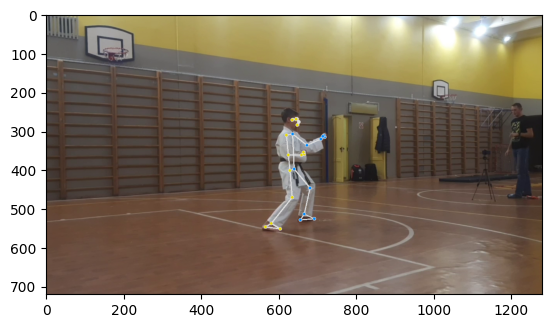

In [144]:
#init
pose_tracker = vision.PoseLandmarker.create_from_options(options)
pose_visualizer = PoseVisualizer()
pose_embedder = FullBodyPoseEmbedder()


# Run classification on a video.

# Open output video.
out_video = cv2.VideoWriter(cfg['output_file'], cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
till_frame_no = 100
output_frame = None

embeddings_list = []

with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
  while video_cap.isOpened():
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
      break
    if frame_idx >= till_frame_no:
      break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format = mp.ImageFormat.SRGB, data=np.array(input_frame))
    detection_result = pose_tracker.detect(mp_image)
    # Draw pose prediction.
    output_frame = input_frame.copy()

    if (detection_result is not None) & len(detection_result.pose_landmarks) > 0 :
      assert hasattr(detection_result, 'pose_landmarks')  , "Unexpected pose_landmakrs attribute not present {}"
      pose_landmarks = detection_result.pose_landmarks[0]
      #for pose_landmarks in pose_landmarks_instances:
      # Get landmarks.
      frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
      pose_landmarks = np.array([
            [lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width] for lmk in pose_landmarks
          ], dtype=np.float32)
      assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)


    else:
      pose_landmarks = None

      print("landmark was not detected")

    # Draw classification plot and repetition counter.
    output_frame = pose_visualizer(
        frame = output_frame,
        detection_result = detection_result)
    embeddings = pose_embedder(landmarks=pose_landmarks)
    embeddings_list.append(embeddings)


    # Save the output frame.
    out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    if frame_idx % 50 == 0:
      show_image(output_frame)

    frame_idx += 1
    pbar.update()

# Close output video.
out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
if output_frame is not None:
  show_image(output_frame)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [146]:
embeddings_list = np.array(embeddings_list) * 10
num_points, num_graphs, _ = np.array(embeddings_list).shape
print(num_points, num_graphs)

100 23


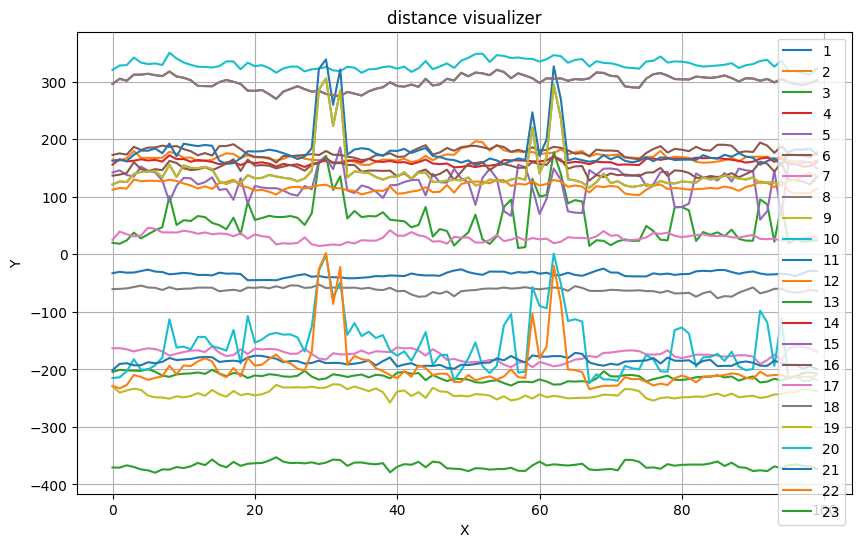

In [147]:
x = np.arange(num_points)
plt.figure(figsize=(10,6))

for i in range(num_graphs):
  y = embeddings_list[:,i,0]
  plt.plot(x,y, label=f'{i+1}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('distance visualizer')
plt.legend()
plt.grid(True)
plt.show()